<a href="https://colab.research.google.com/github/tiffanylin43/BME590L_Final_Project_addon/blob/add_noise/BME590L_addon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/tiffanylin43/BME590L_Final_Project_addon.git

fatal: destination path 'BME590L_Final_Project_addon' already exists and is not an empty directory.


# **Import Data**

Define function for reading in data

In [0]:
%tensorflow_version 1.x
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

Read in data

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


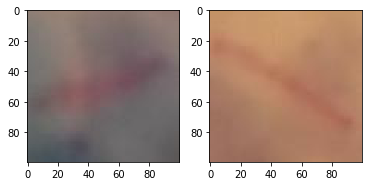

In [3]:
tb_img_arr, tb_label = read_feature('./BME590L_Final_Project_addon/TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./BME590L_Final_Project_addon/Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

Add noise

In [0]:
sigma = 50
noise = np.random.randn(100,100,3)*sigma
X_train = X_train + noise
X_val = X_val + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


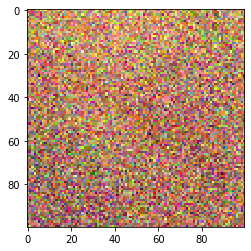

In [5]:
plt.imshow(X_train[0].reshape(100, 100, 3)/255, cmap=plt.cm.Greys);
plt.imshow(X_train[1].reshape(100, 100, 3)/255, cmap=plt.cm.Greys);

In [6]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Create trainable weights for each color channel


In [0]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)

Creating mask based on the weights of different channels

In [8]:
mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

(100, 100, 3)


Put the mask on images

In [0]:
image = mask * X_batch

Define trainning loop and calculate statistics for analysis

In [0]:
def train_loop_train(iteration):
    # train loop:
    correct = 0
    total = 0
    loss_list = []
    acc_list = []
    TP = 0
    TN = 0
    AP = 0
    AN = 0
    for i in range(iteration):
        _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
        acc1 = correct/total
        TPi, TNi, APi, ANi = stat(prediction.argmax(1), truth)
        TP = TP + TPi
        TN = TN + TNi
        AP = AP + APi
        AN = AN + ANi
        
        if i%1000 == 0:
            print('loss is ', loss_i)
            loss_list.append(loss_i)
            acc_list.append(acc1)    
          
    sensitivity = TP/AP
    specificity = TN/AN
    acc = correct/total
    print("Accuracy is:")
    print(acc)
    print("Sensitivity is:")
    print(sensitivity)
    print("Specificity is:")
    print(specificity)
    return loss_list, sensitivity, specificity, acc_list

In [0]:
def train_loop_val(iteration):
    # train loop:
    correct = 0
    total = 0
    loss_list = []
    acc_list = []
    TP = 0
    TN = 0
    AP = 0
    AN = 0
    for i in range(iteration):
        _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
        acc1 = correct/total
        TPi, TNi, APi, ANi = stat(prediction.argmax(1), truth)
        TP = TP + TPi
        TN = TN + TNi
        AP = AP + APi
        AN = AN + ANi
        
        if i%10 == 0:
            print('loss is ', loss_i)
            loss_list.append(loss_i)
            acc_list.append(acc1)    
          
    sensitivity = TP/AP
    specificity = TN/AN
    acc = correct/total
    print("Accuracy is:")
    print(acc)
    print("Sensitivity is:")
    print(sensitivity)
    print("Specificity is:")
    print(specificity)
    return loss_list, sensitivity, specificity, acc_list

In [0]:
def stat(prediction, truth):
    pred_pos = np.where(prediction == 1)
    label_pos = np.where(truth == 1)
    TP = len(np.intersect1d(pred_pos, label_pos))

    pred_neg = np.where(prediction == 0)
    label_neg = np.where(truth == 0)
    TN = len(np.intersect1d(pred_neg, label_neg))
    
    AP = len(label_pos[0])
    AN = len(label_neg[0])
    return TP, TN, AP, AN
             
    specificity = TN/AB
    sensitivity = TP/AP

# **Trainning with a network wrote in previous homework**

Learning_rate = 0.0001

In [13]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.0001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

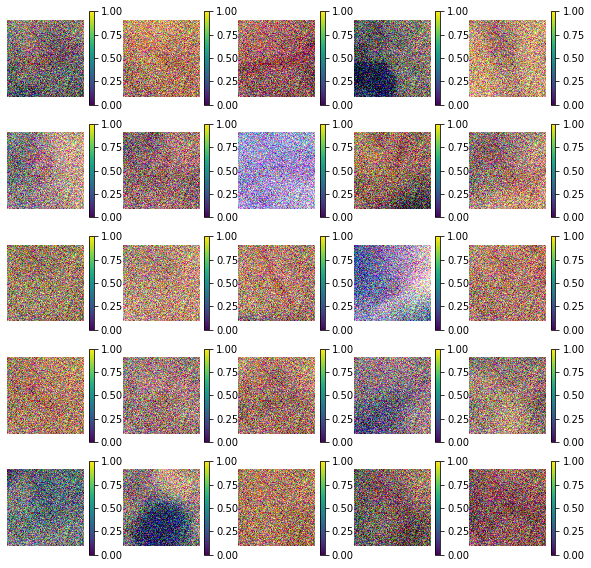

In [15]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [16]:
loss_list_train, sensitivity_train, specificity_train, acc_list_train = train_loop_train(10000)

loss is  12.053658
loss is  0.2598483
loss is  0.14781016
loss is  0.1762552
loss is  0.08688632
loss is  0.11770011
loss is  0.14277941
loss is  0.077619195
loss is  0.18115212
loss is  0.08867051
Accuracy is:
0.9163289376278246
Sensitivity is:
0.8911143190836482
Specificity is:
0.9355384232777916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

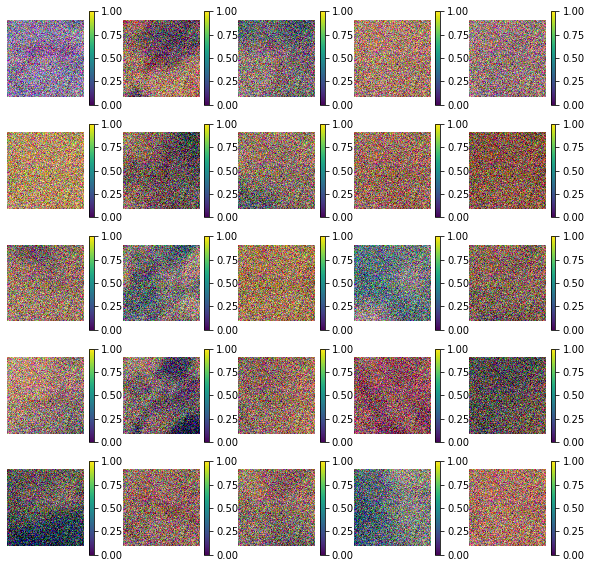

In [17]:
# plot examples 
plot_examples(image.eval())

In [18]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

loss_list_test, sensitivity_test, specificity_test, acc_list_test = train_loop_val(100)

loss is  0.20268661
loss is  0.2764465
loss is  0.046500757
loss is  0.17804344
loss is  0.3166527
loss is  0.041301474
loss is  0.0852883
loss is  0.07423224
loss is  0.12931381
loss is  0.34512576
Accuracy is:
0.9507672634271099
Sensitivity is:
0.9324026451138868
Specificity is:
0.9649122807017544


function for plots


In [0]:
def plot_and_calculate(loss_train, acc_train, loss_test, acc_test):
    plt.plot(loss_train, 'r-o')
    plt.title("Training loss")
    plt.show()
    plt.plot(acc_train,'g-o')
    plt.title("Training accuracy")
    plt.show()
    plt.plot(loss_test, 'r-o')
    plt.title("Validation loss")
    plt.show()
    plt.plot(acc_test,'g-o')
    plt.title("Validation accuracy")
    plt.show()  

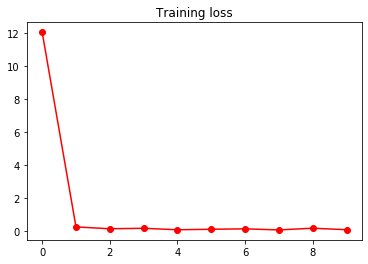

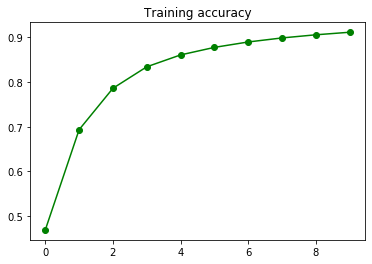

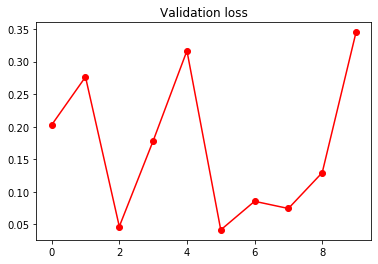

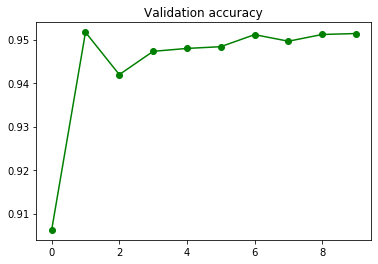

In [20]:
plot_and_calculate(loss_list_train, acc_list_train, loss_list_test, acc_list_test)

## Trainning result of the weights of each channel

In [21]:
sess.run(w_r)

0.88972294

In [22]:
sess.run(w_g)

0.89628917

In [23]:
sess.run(w_b)

1.0

# **Classification without training of color channels**

In [0]:
train_r = False
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = False
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = False
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)
image = mask * X_batch

In [25]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.0001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [26]:
loss_train, sensitivity, specificity, acc_train = train_loop_train(10000)

loss is  8.925513
loss is  0.24483576
loss is  0.3886555
loss is  0.1774914
loss is  0.1262248
loss is  0.04852505
loss is  0.04862275
loss is  0.092059776
loss is  0.2084903
loss is  0.12554613
Accuracy is:
0.9309683935808479
Sensitivity is:
0.9103049558960075
Specificity is:
0.9467116171106444


In [27]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})
loss_test, sensitivity, specificity, acc_test = train_loop_val(100)

loss is  0.18892376
loss is  0.328785
loss is  0.04629053
loss is  0.1406956
loss is  0.30032444
loss is  0.026798181
loss is  0.09354159
loss is  0.07298487
loss is  0.09419284
loss is  0.31959742
Accuracy is:
0.9514066496163683
Sensitivity is:
0.9375459221160911
Specificity is:
0.9620826259196378


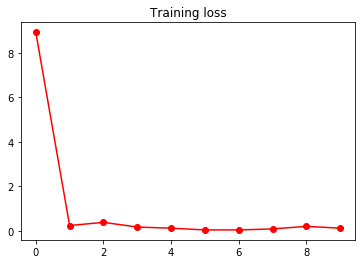

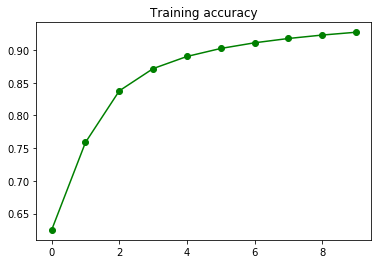

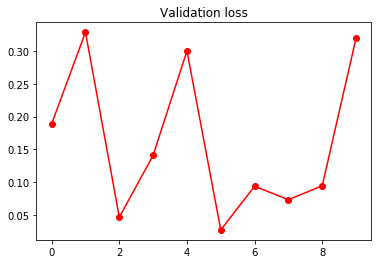

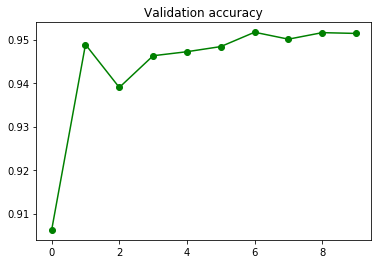

In [28]:
plot_and_calculate(loss_train, acc_train, loss_test, acc_test)

In [29]:
sess.run(w_r)

1.0

In [30]:
sess.run(w_g)

1.0

In [31]:
sess.run(w_b)

1.0